In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training lists,test lists,data_size,test_size,extra_info,score_name,p_continue,noise_scale,run_i,rand_seed
0,uci wine example,Stan inspection model,0.350382,0.351053,0.635400,inf,100,100,6497,6017,"{""est_p_continue"": 0.72857055225}",quality,0.8,0.87,0,518677876
1,uci wine example,Stan list utility model,0.388667,0.389750,0.798375,0.371842,100,100,6497,6017,NaN,quality,0.8,0.87,0,518677876
2,uci wine example,Stan difference utility model,0.392742,0.394271,0.794513,0.382070,100,100,6497,6017,NaN,quality,0.8,0.87,0,518677876
3,uci wine example,"logistic differences, early stop=T",0.265737,0.268926,0.295538,0.552384,100,100,6497,6017,NaN,quality,0.8,0.87,0,518677876
4,uci wine example,"logistic differences, early stop=F",0.405049,0.406714,0.790425,0.430544,100,100,6497,6017,NaN,quality,0.8,0.87,0,518677876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,uci wine example,Stan difference utility model,0.373974,0.367943,0.769813,0.379843,100,100,6497,6021,NaN,quality,0.8,0.87,49,457751914
346,uci wine example,"logistic differences, early stop=T",0.234355,0.227633,0.259850,0.559515,100,100,6497,6021,NaN,quality,0.8,0.87,49,457751914
347,uci wine example,"logistic differences, early stop=F",0.379072,0.373278,0.760275,0.440355,100,100,6497,6021,NaN,quality,0.8,0.87,49,457751914
348,uci wine example,logistic items,0.374459,0.368607,0.776575,0.438444,100,100,6497,6021,NaN,quality,0.8,0.87,49,457751914


In [3]:
n_draws = int(np.max(d['run_i']) + 1)
n_lists = int(np.mean(d['training lists']))

In [4]:
d_SpearmanR = d.loc[:, ['estimate_name', 'SpearmanR_test']].reset_index(drop=True, inplace=False)
d_SpearmanR['is_Stan_model'] = [nm.startswith('Stan ') for nm in d_SpearmanR['estimate_name']]
ideal_score = d_SpearmanR.loc[d_SpearmanR['estimate_name'] == 'observed score', 'SpearmanR_test'].mean()
d_SpearmanR = d_SpearmanR.loc[d_SpearmanR['estimate_name'] != 'observed score', :]

d_SpearmanR

,estimate_name,SpearmanR_test,is_Stan_model
0,Stan inspection model,0.351053,True
1,Stan list utility model,0.389750,True
2,Stan difference utility model,0.394271,True
3,"logistic differences, early stop=T",0.268926,False
4,"logistic differences, early stop=F",0.406714,False
...,...,...,...
344,Stan list utility model,0.368475,True
345,Stan difference utility model,0.367943,True
346,"logistic differences, early stop=T",0.227633,False
347,"logistic differences, early stop=F",0.373278,False


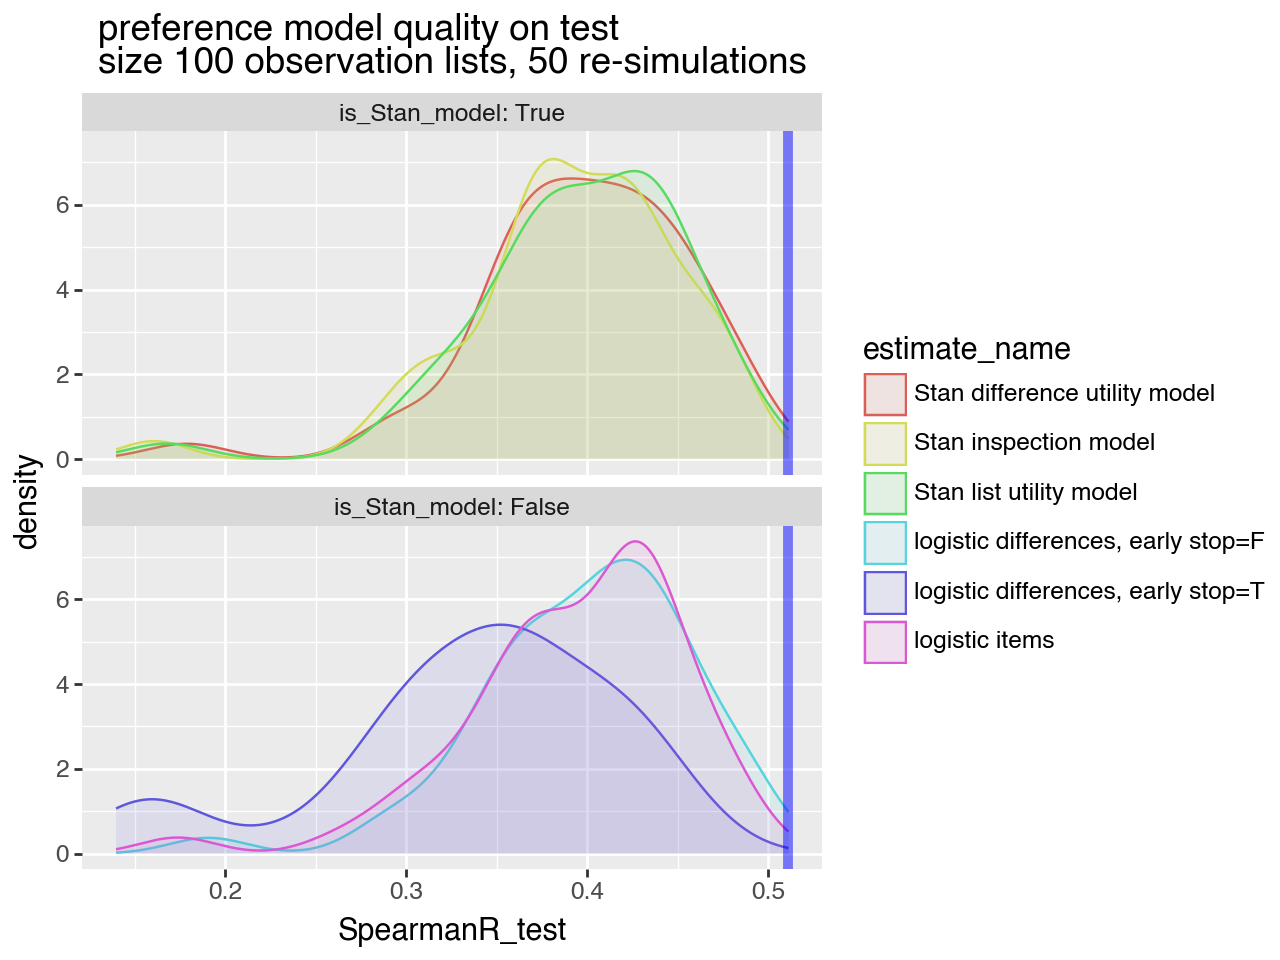

In [5]:
(
    ggplot(
        data=d_SpearmanR,
        mapping=aes(
            x='SpearmanR_test',
            color='estimate_name',
            fill='estimate_name',
        )
    )
    + facet_wrap(
        'is_Stan_model', 
        ncol=1, 
        labeller='label_both',
        as_table=False,
        )
    + geom_density(alpha=0.1)
    + geom_vline(xintercept=ideal_score, color='blue', alpha=0.5, size=2)
    + ggtitle(f"preference model quality on test\nsize {n_lists} observation lists, {n_draws} re-simulations")
)

In [6]:
de = d.loc[d['estimate_name'] == 'Stan inspection model', ['test lists', 'extra_info']].reset_index(drop=True, inplace=False)
de['est_p_continue'] = [json.loads(v)['est_p_continue'] for v in de['extra_info']]
de.head()

,test lists,extra_info,est_p_continue
0,100,"{""est_p_continue"": 0.72857055225}",0.728571
1,100,"{""est_p_continue"": 0.7784967597499999}",0.778497
2,100,"{""est_p_continue"": 0.78831090075}",0.788311
3,100,"{""est_p_continue"": 0.7507757525}",0.750776
4,100,"{""est_p_continue"": 0.73162611575}",0.731626


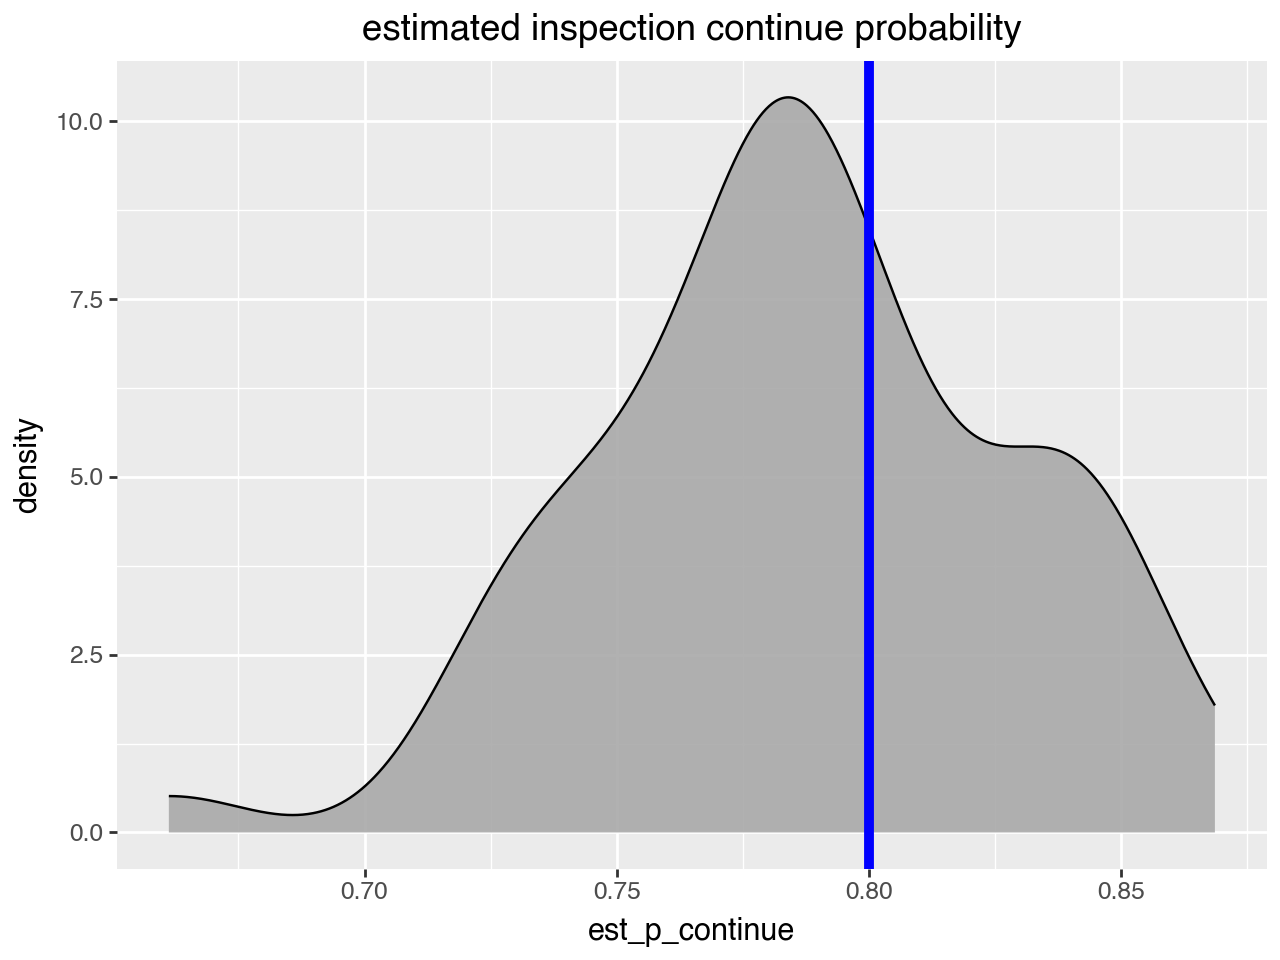

In [7]:
(
    ggplot(
        data=de,
        mapping=aes(x='est_p_continue')
    )
    + geom_density(fill='darkgrey', alpha=0.9)
    + geom_vline(xintercept=np.mean(d['p_continue']), color='blue', size=2)
    + ggtitle("estimated inspection continue probability")
)

